# <Center> **Tarea 2**

  **<Center>Machine Learning**

  **<Center> José Miguel Muñoz Arias**

Usando otro Dataset
---



---



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split as tts
plt.style.use('seaborn')
import joblib
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Un modelo de NN sencillo

Para la implementación generalizada del modelo de Adaboost, uso un modelo neuronal sencillo con limitador duro programado con OOP.

Uso la Clase **Modelos** que tiene varios parámetros variables como el alfa, número de neuronas en la capa oculta, y número de iteraciones. También tiene algunos métodos útiles como **entrenar**, **predecir** y **guardar**, este último lo programé con Joblib para poder ir guardando y llamando los modelos en el Boost


In [ ]:
class Modelos:

  def __init__(self,xTrain,yTrain,alfa,nNeuronas,previo=False,nombreArchivo="",guardar=100):
    self.xTrain=xTrain
    self.yTrain=yTrain
    self.alfa=alfa
    self.nNeuronas=nNeuronas
    self.guardar=guardar
    self.previo=previo
    self.nombreArchivo=nombreArchivo
    if self.previo==True:
      w1=self.cargarModelo(self.nombreArchivo)["w1"].astype(float)
      w2=self.cargarModelo(self.nombreArchivo)["w2"].astype(float)
      b1=self.cargarModelo(self.nombreArchivo)["b1"].astype(float)
      b2=self.cargarModelo(self.nombreArchivo)["b2"].astype(float)
      self.modelo={"w1":w1,"b1":b1,"w2":w2,"b2":b2}
    else:
      self.modelo={}

  def calcularCosto(self,y,a2):
    costo=np.sum(np.power(y-a2,2))/y.shape[1]
    return costo

  def graficarCostos(self,costos):
      plt.figure(figsize=(8,6))
      plt.plot(costos['iteracion'],costos['costos'])
      plt.title('Costo vs iteraciones',size=20)
      plt.xlabel('Iteraciones',size=14,weight=1000)
      plt.ylabel('Costo (error)',size=14,weight=1000)
      plt.xticks(costos['iteracion'],size=14,rotation=-90)
      plt.yticks(size=14)
      plt.grid(color='powderblue',linewidth=2)
      plt.show() 

  def calcularExactitud(self,yPred,y):
      error=np.abs((yPred-y)/y)
      exactitud=100*(1-np.mean(error))
      return round(exactitud,2)

  def inicializarModelo(self,entradas):
    
    w1=np.random.uniform(-0.0001,0.0001,(self.nNeuronas,entradas))
    b1=np.zeros((self.nNeuronas,1))
    w2=np.random.uniform(-0.0001,0.0001,(1,self.nNeuronas))
    b2=np.zeros((1,1))
    self.save("modelo0")
    if self.previo==True:
      w1=self.cargarModelo(self.nombreArchivo)["w1"].astype(float)
      w2=self.cargarModelo(self.nombreArchivo)["w2"].astype(float)
      b1=self.cargarModelo(self.nombreArchivo)["b1"].astype(float)
      b2=self.cargarModelo(self.nombreArchivo)["b2"].astype(float)
      self.modelo={"w1":w1,"b1":b1,"w2":w2,"b2":b2}
    return {"w1":w1,"b1":b1,"w2":w2,"b2":b2}

  def entrenarModelo(self,x,y,iteraciones,aprendizaje): 
      self.modelo=self.inicializarModelo(x.shape[1])
      costos={'iteracion':[],'costos':[]} 
      for i in range(iteraciones):
          activaciones=self.propagacionAdelante(x,self.modelo)
          self.modelo=self.propagacionAtras(self.modelo,activaciones,x,y,aprendizaje)
          if i%self.guardar==0:
              costo=self.calcularCosto(activaciones['a2'],y)
              costos['iteracion'].append(i)
              costos['costos'].append(costo)
              print ("Costo en iteracion {}: {}".format(i,costo))
      return self.modelo,costos

  def propagacionAdelante(self,x, modelo):
      x=np.array(x)
      z1=np.dot(self.modelo['w1'].astype(float),x.T)+self.modelo['b1'].astype(float)
      a1=np.tanh(z1) 
      z2=np.dot(self.modelo['w2'].astype(float),a1.astype(float))+self.modelo['b2'].astype(float)
      a2=z2 #
      return {"a1":a1,"a2":a2}

  def propagacionAtras(self, modelo, activaciones, x, y, aprendizaje):
      m = y.shape[1] 
      dz2 = 2*(activaciones['a2']-y) #
      dw2 = np.matmul(dz2,activaciones['a2'].T)/m
      db2 = np.sum(dz2,axis=1,keepdims=True)/m
      dz1 = np.matmul(self.modelo['w2'].T,dz2)*(1-np.power(activaciones['a1'],2))
      dw1 = np.matmul(dz1,x)/m
      db1 = np.sum(dz1,axis=1,keepdims=True)/m
      w1 = self.modelo['w1']-aprendizaje*dw1
      b1 = self.modelo['b1']-aprendizaje*db1
      w2 = self.modelo['w2']-aprendizaje*dw2
      b2 = self.modelo['b2']-aprendizaje*db2
      return {"w1":w1,"b1":b1,"w2":w2,"b2":b2}

  def predecir(self, entradas):
      activaciones = self.propagacionAdelante(entradas, self.modelo)
      yPred = activaciones['a2'] 
      return yPred

  def entrenar(self):
    self.modelo,costos=self.entrenarModelo(
    self.xTrain,
    self.yTrain,
    iteraciones=1000,
    aprendizaje=self.alfa)
    self.graficarCostos(costos)
    
  def save(self,nombre):
    joblib.dump(self.modelo,nombre+".pkl")

  def cargarModelo(self,nombreArchivo):
    modelo=joblib.load(nombreArchivo+".pkl")
    return modelo

# <center>**Modelo Gradient Boosting**

Esta clase **GradBoost** permite hacer un Boosting del modelo de la clase Modelos (que virtualmente puede ser cualquier otro modelo de ML que use gradiente descendente, de ahí su nombre).

La idea es que se corre después de haber inicializado el modelo de **Modelos**, se le pase como parámetro el modelo en conjunto con los datos a entrenar, el alfa para el Modelo, y el número de votantes para hacer la votación (que está implementa en un método).

Finalmente, el modelo completo entrena llamando el método predecir, que recibe como parámetro algún dato (o conjunto) para hacer la votación.

In [ ]:
class GradBoost:

  def __init__(self, Modelo, X, Y, nReps, alfa=0.02 ,clasificaFuerte=True, nBoost=100, nNeuronas=10):

    self.Modelo=Modelo
    self.X=X
    self.Y=Y
    self.nReps=nReps
    self.modGuardado=[]
    self.nNeuronas=nNeuronas
    self.alfa=alfa
    self.nBoost=nBoost
    self.xTrain,self.xTest,self.yTrain,self.yTest = tts(self.X, self.Y, test_size=0.3, random_state=1)
    self.s=20*"*"
    self.ValorModelos=[]
    self.pathModelosGenerados=[]
    self.prediccion=np.zeros(len(self.yTrain))
    self.df=pd.DataFrame(xTrain,columns=self.X.columns)
    self.df["prediccion"]=self.prediccion
    self.df["yTrain"]=self.yTrain
    
    
  def normalizar(self,X):
    scalerNorm = MinMaxScaler()
    scalerNorm.fit(X) # Se calculan minimo y maximo
    return scalerNorm.transform(X) # Se aplica la formula a cada entrada

  def entrenarBoost(self):
    for SupIter in range(self.nReps):
      print(self.s);print("Entrenando Boost {} ".format(SupIter));print(self.s)
      # entrenar el modelo 
      self.Modelo.entrenar()
      # guardar el modelo 
      self.Modelo.save("modelo"+ str(SupIter))

      self.pathModelosGenerados.append("modelo"+ str(SupIter))
      # predecir con el modelo guardado y calcular exactitud
      self.ValorModelos.append(self.evaluarSay())
      self.xTrain,self.yTrain=self.Boostear()
      self.prediccion = self.Modelo.predecir(self.xTrain)
      self.df["prediccion"] = self.prediccion.flatten()


  def votar(self,x_toPredecir):
    resul=[]
    for SupIter in range(self.nReps):
      nombre=self.pathModelosGenerados[SupIter]
      modelo=Modelos(self.xTrain,self.xTrain,self.alfa,self.nNeuronas,previo=True,nombreArchivo=nombre)
      prediccionEste=modelo.predecir(x_toPredecir)
      resul.append(prediccionEste*self.ValorModelos[SupIter])
    ponderado=np.sum(resul)
    return ponderado

  def desicion(self,ponderado,thereshold=0.5):
    if ponderado>=thereshold: return 1
    else: return 0

  def evaluarSay(self):
      correctos = self.df[self.df["prediccion"]==self.df["yTrain"]]
      incorrectos = self.df[self.df["prediccion"]!=self.df["yTrain"]]
      if len(incorrectos["yTrain"])==0: return 1
      else: return (1/2)*np.log(len(correctos["yTrain"])/len(incorrectos["yTrain"])) # Lo saqué de StatQuest ¯\_(ツ)_/¯ (Mejora mucho el entrenamiento!)


  def Boostear(self):
     
      correctos = self.df[self.df[["prediccion"]].eq(self.df[["yTrain"]])]
      porcCorrectos=len(correctos)/len(self.df[["prediccion"]])
      incorrectos = self.df[self.df[["prediccion"]].ne(self.df[["yTrain"]])]
      nuevosCorrectos=correctos.sample(int(self.nBoost*porcCorrectos),replace=True)
      nuevosIncorrectos=incorrectos.sample(int(self.nBoost*(1-porcCorrectos)),replace=True)
      self.df.append(nuevosCorrectos)
      self.df.append(nuevosIncorrectos)
      return self.xTrain,self.yTrain

  def predecir(self,x):
    np.seterr(divide = 'ignore') #Para que no llore por divisiones por cero ಠ_ಠ
    self.entrenarBoost()
    pond = self.votar(x)
    print(self.s);print("La votación realizada para {} es:".format(x))
    return self.desicion(pond)



********************
Entrenando Boost 0 
********************
Costo en iteracion 0: 0.48194627343977114
Costo en iteracion 100: 0.4713895828821961
Costo en iteracion 200: 0.4643110560050041
Costo en iteracion 300: 0.4595530050680822
Costo en iteracion 400: 0.4563398877883893
Costo en iteracion 500: 0.4541544024431104
Costo en iteracion 600: 0.45265148739132854
Costo en iteracion 700: 0.45160053463291244
Costo en iteracion 800: 0.45084723131507287
Costo en iteracion 900: 0.45028837698062646


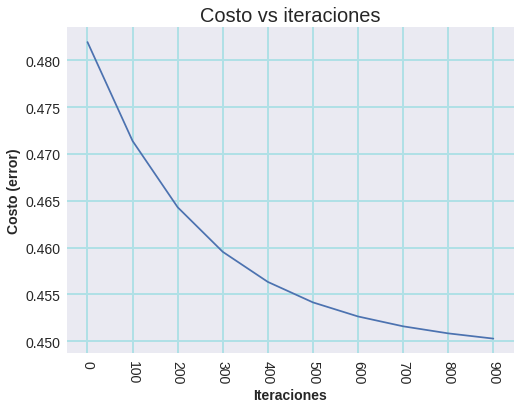

********************
Entrenando Boost 1 
********************
Costo en iteracion 0: 0.4819462802628107
Costo en iteracion 100: 0.47138968386125474
Costo en iteracion 200: 0.4643110190382787
Costo en iteracion 300: 0.4595524681914658
Costo en iteracion 400: 0.45633858865041377
Costo en iteracion 500: 0.4541521846208244
Costo en iteracion 600: 0.45264826196260194
Costo en iteracion 700: 0.45159624643476715
Costo en iteracion 800: 0.45084183803331174
Costo en iteracion 900: 0.4502818383123435


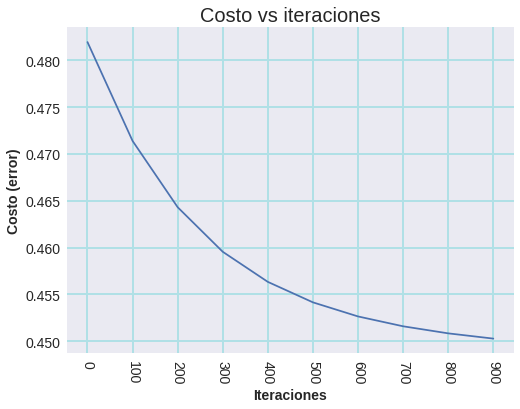

********************
Entrenando Boost 2 
********************
Costo en iteracion 0: 0.48194628466057027
Costo en iteracion 100: 0.4713898429154062
Costo en iteracion 200: 0.4643116094429483
Costo en iteracion 300: 0.4595536291526659
Costo en iteracion 400: 0.4563403497472194
Costo en iteracion 500: 0.4541545356049704
Costo en iteracion 600: 0.4526511974737965
Costo en iteracion 700: 0.45159978351323393
Costo en iteracion 800: 0.4508460170913669
Costo en iteracion 900: 0.45028671705722345


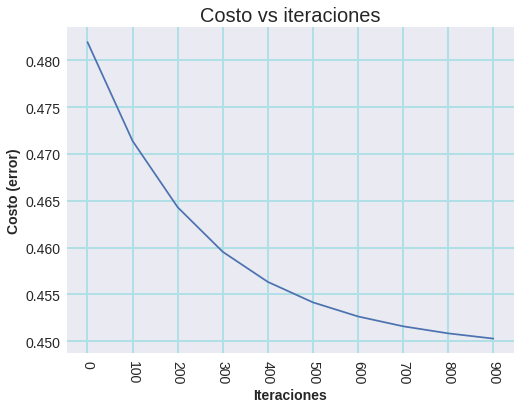

********************
Entrenando Boost 3 
********************
Costo en iteracion 0: 0.4819462962006051
Costo en iteracion 100: 0.4713903735187087
Costo en iteracion 200: 0.46431320684732985
Costo en iteracion 300: 0.4595564008851529
Costo en iteracion 400: 0.4563442283701103
Costo en iteracion 500: 0.4541593976747663
Costo en iteracion 600: 0.4526569142484542
Costo en iteracion 700: 0.45160624071496985
Costo en iteracion 800: 0.4508531210346336
Costo en iteracion 900: 0.45029439508449


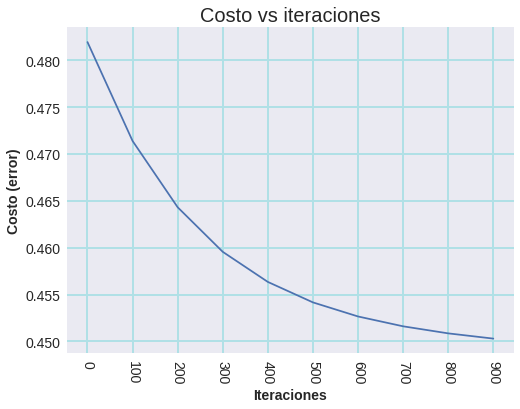

********************
La votación realizada para [2, 2] es:


1

In [ ]:
def preprocesamiento(datos,porcentaje,semilla):
    xTrain,xTest,yTrain,yTest = tts(datos[['x1','x2']],
                                     datos['y'],
                                     test_size=porcentaje,
                                     random_state=semilla)
    xTrain=xTrain.to_numpy()
    xTest=xTest.to_numpy()
    yTrain=yTrain.to_numpy().reshape(1,yTrain.shape[0])
    yTest=yTest.to_numpy().reshape(1,yTest.shape[0])
    return xTrain,xTest,yTrain,yTest
datos=pd.read_csv("/content/datos (1).csv")
datos['x2']=datos['x1'].apply(np.sin)
xTrain,xTest,yTrain,yTest=preprocesamiento(datos,0.3,1)



miModelo=Modelos(xTrain,yTrain,0.001,10,1000)

adaBoost=GradBoost(miModelo,datos[['x1','x2']],datos[["y"]],4)
adaBoost.predecir([2,2])

## Es un resultado positivo!

Es posible ver una reducción en los costos de cada último entrenamiento, además, si se le aplica la prueba a YTest, se denota un mejora con respecto al modelo insulso